In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text
import chess
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

print("✅ Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

✅ Libraries imported successfully!
TensorFlow version: 2.20.0
GPU available: []


In [2]:
# Database configuration
DB_USER = os.getenv('USER')
DB_NAME = 'chess_app'
DATABASE_URL = f'postgresql://{DB_USER}:@localhost:5432/{DB_NAME}'

# Create engine
engine = create_engine(DATABASE_URL, echo=False)

# Test connection
with engine.connect() as conn:
    positions_count = conn.execute(text("SELECT COUNT(*) FROM positions;")).fetchone()[0]
    print(f"✅ Connected to database!")
    print(f"📊 Total positions available: {positions_count:,}")

✅ Connected to database!
📊 Total positions available: 148,320


In [3]:
print("Loading position data for training...")

# Start with a manageable sample (10,000 positions)
# We'll scale up after the model works
positions_df = pd.read_sql("""
    SELECT 
        p.position_id,
        p.game_id,
        p.move_number,
        p.fen,
        p.move_played,
        g.white_elo,
        g.black_elo,
        g.result
    FROM positions p
    JOIN games g ON p.game_id = g.game_id
    WHERE g.white_elo > 1400  -- Focus on decent quality games
    ORDER BY RANDOM()
    LIMIT 10000;
""", engine)

print(f"✅ Loaded {len(positions_df):,} positions for training")
print(f"\nSample data:")
positions_df.head()

Loading position data for training...
✅ Loaded 10,000 positions for training

Sample data:


,position_id,game_id,move_number,fen,move_played,white_elo,black_elo,result
0,82211,1221,48,3q1rk1/7p/r1p1p3/p1bpn3/P5N1/8/3B1PPN/1RQ2RK1 ...,Nxg4,2285,2292,1-0
1,48952,712,68,4r3/q2n1kb1/6p1/5p2/2Q1pB2/8/6PP/3R3K b - - 0 34,Kf8,2135,2064,0-1
2,21458,318,7,rnbqkb1r/pp1p1ppp/2p1pn2/8/3PP3/5N2/PPP2PPP/RN...,e5,1920,1978,0-1
3,6532,99,9,rn1qkb1r/ppp1pppp/8/3n1b2/3P4/2N5/PPP2PPP/R1BQ...,Nf3,1722,1744,0-1
4,40518,596,92,8/p2r1k2/R4pp1/7p/5K2/6P1/6P1/8 b - - 11 46,Rb7,1886,1920,1-0


In [4]:
def fen_to_features(fen):
    """
    Convert FEN notation to numeric features
    
    Returns a vector of features representing the board state
    """
    # Split FEN into components
    parts = fen.split(' ')
    board_str = parts[0]
    
    # Piece mapping to numbers
    piece_map = {
        'P': 1, 'N': 2, 'B': 3, 'R': 4, 'Q': 5, 'K': 6,  # White pieces
        'p': -1, 'n': -2, 'b': -3, 'r': -4, 'q': -5, 'k': -6,  # Black pieces
        '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0  # Empty squares
    }
    
    # Initialize 8x8 board
    board = np.zeros(64, dtype=int)
    
    # Parse board position
    square = 0
    for char in board_str:
        if char == '/':
            continue
        elif char.isdigit():
            square += int(char)  # Skip empty squares
        else:
            board[square] = piece_map.get(char, 0)
            square += 1
    
    # Additional features
    to_move = 1 if parts[1] == 'w' else -1  # Who's turn
    
    # Combine all features
    features = np.concatenate([
        board,  # 64 features for board
        [to_move]  # 1 feature for whose turn
    ])
    
    return features

# Test the function
sample_fen = positions_df.iloc[0]['fen']
sample_features = fen_to_features(sample_fen)

print(f"✅ Feature engineering function created!")
print(f"Sample FEN: {sample_fen}")
print(f"Feature vector shape: {sample_features.shape}")
print(f"Feature vector sample (first 10): {sample_features[:10]}")

✅ Feature engineering function created!
Sample FEN: 3q1rk1/7p/r1p1p3/p1bpn3/P5N1/8/3B1PPN/1RQ2RK1 b - - 0 24
Feature vector shape: (65,)
Feature vector sample (first 10): [ 0  0  0 -5  0 -4 -6  0  0  0]


In [5]:
print("Preparing training data...")

# Convert all positions to features
X = np.array([fen_to_features(fen) for fen in positions_df['fen']])

# Encode moves as labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(positions_df['move_played'])

print(f"✅ Data prepared!")
print(f"   X shape: {X.shape} (samples, features)")
print(f"   y shape: {y.shape} (samples,)")
print(f"   Unique moves: {len(label_encoder.classes_)}")
print(f"   Sample moves: {label_encoder.classes_[:10]}")

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\n📊 Train/Test Split:")
print(f"   Training samples: {len(X_train):,}")
print(f"   Testing samples: {len(X_test):,}")

Preparing training data...
✅ Data prepared!
   X shape: (10000, 65) (samples, features)
   y shape: (10000,) (samples,)
   Unique moves: 1188
   Sample moves: ['Ba1' 'Ba2' 'Ba3' 'Ba4' 'Ba4+' 'Ba5' 'Ba6' 'Ba6+' 'Ba7' 'Ba8']

📊 Train/Test Split:
   Training samples: 8,000
   Testing samples: 2,000


In [6]:
print("Building neural network...")

# Number of possible moves (output classes)
num_classes = len(label_encoder.classes_)

# Build the model
model = keras.Sequential([
    # Input layer
    layers.Input(shape=(65,)),
    
    # Hidden layers
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),  # Prevent overfitting
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    
    # Output layer - probability for each possible move
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Model built!")
print("\nModel Architecture:")
model.summary()

Building neural network...
✅ Model built!

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1188)           │        77,220 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,268 (528.39 KB)

 Trainable params: 135,268 (528.39 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
print("=" * 60)
print("🚀 TRAINING NEURAL NETWORK")
print("=" * 60)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,  # Number of training iterations
    batch_size=32,
    validation_split=0.2,  # Use 20% of training data for validation
    verbose=1
)

print("\n✅ Training complete!")

🚀 TRAINING NEURAL NETWORK
Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0133 - loss: 6.4348 - val_accuracy: 0.0244 - val_loss: 6.2149
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0219 - loss: 6.0212 - val_accuracy: 0.0262 - val_loss: 6.1645
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0277 - loss: 5.8772 - val_accuracy: 0.0312 - val_loss: 6.1593
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0323 - loss: 5.7558 - val_accuracy: 0.0413 - val_loss: 6.1724
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0394 - loss: 5.6346 - val_accuracy: 0.0406 - val_loss: 6.1373
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0427 - loss: 5.4938 - val_accuracy: 0.0381 - val_loss: 6.1198
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0466 - loss: 5.3645 - val_accuracy: 0.0481 - val_loss: 6.1230
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0558 - loss:

In [8]:
print("=" * 60)
print("📊 MODEL EVALUATION")
print("=" * 60)

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"\n🎯 Test Results:")
print(f"   Loss: {test_loss:.4f}")
print(f"   Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Make predictions on a few samples
sample_indices = np.random.choice(len(X_test), 5)
sample_predictions = model.predict(X_test[sample_indices], verbose=0)

print(f"\n🔮 Sample Predictions:")
for i, idx in enumerate(sample_indices):
    true_move = label_encoder.inverse_transform([y_test[idx]])[0]
    predicted_move_idx = np.argmax(sample_predictions[i])
    predicted_move = label_encoder.classes_[predicted_move_idx]
    confidence = sample_predictions[i][predicted_move_idx] * 100
    
    print(f"\n   Position {i+1}:")
    print(f"      True move: {true_move}")
    print(f"      Predicted: {predicted_move} (confidence: {confidence:.1f}%)")
    
    # Show top 3 predictions
    top_3_indices = np.argsort(sample_predictions[i])[-3:][::-1]
    print(f"      Top 3 predictions:")
    for j, move_idx in enumerate(top_3_indices):
        move = label_encoder.classes_[move_idx]
        prob = sample_predictions[i][move_idx] * 100
        print(f"         {j+1}. {move} ({prob:.1f}%)")

📊 MODEL EVALUATION

🎯 Test Results:
   Loss: 6.7347
   Accuracy: 0.0695 (6.95%)

🔮 Sample Predictions:

   Position 1:
      True move: Rf6
      Predicted: Nde5 (confidence: 2.0%)
      Top 3 predictions:
         1. Nde5 (2.0%)
         2. Qb6 (1.5%)
         3. b5 (1.5%)

   Position 2:
      True move: Nf7
      Predicted: O-O (confidence: 12.9%)
      Top 3 predictions:
         1. O-O (12.9%)
         2. Qc7 (5.8%)
         3. Be7 (4.3%)

   Position 3:
      True move: Nf3
      Predicted: d4 (confidence: 18.7%)
      Top 3 predictions:
         1. d4 (18.7%)
         2. Nf3 (18.3%)
         3. e4 (14.1%)

   Position 4:
      True move: Bb7
      Predicted: g6 (confidence: 3.9%)
      Top 3 predictions:
         1. g6 (3.9%)
         2. a5 (3.2%)
         3. c5 (3.2%)

   Position 5:
      True move: Nh2
      Predicted: Qd2 (confidence: 3.1%)
      Top 3 predictions:
         1. Qd2 (3.1%)
         2. f4 (2.1%)
         3. Nxe4 (2.1%)


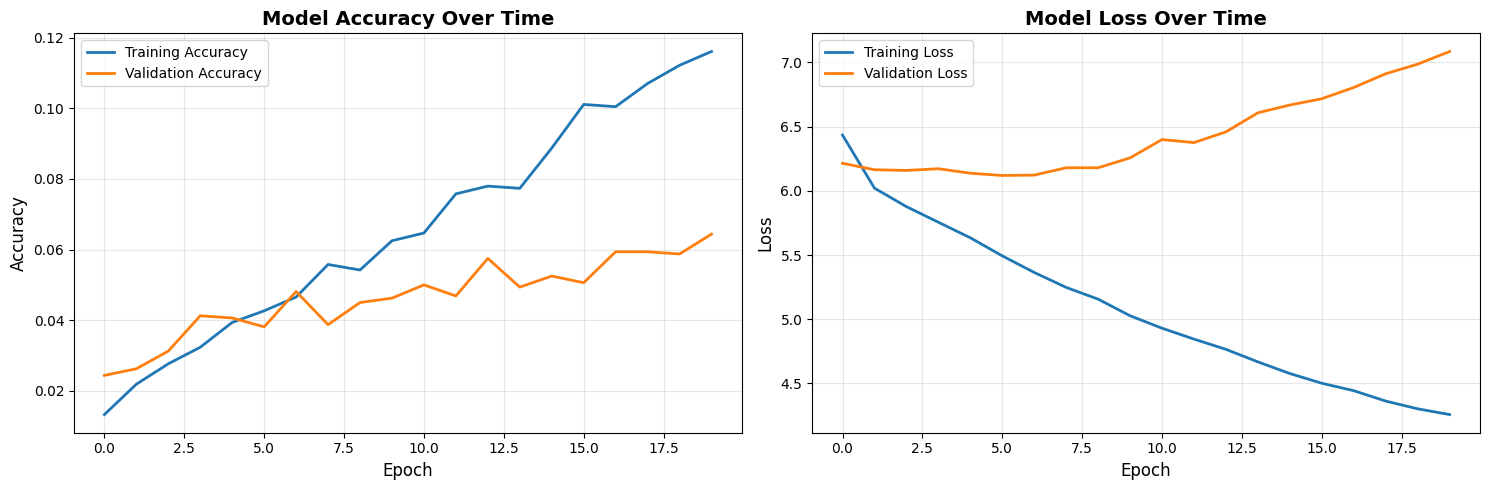


📈 Training curves show learning progress!


In [9]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📈 Training curves show learning progress!")

In [10]:
print("=" * 60)
print("💾 SAVING MODEL")
print("=" * 60)

# Create models directory
os.makedirs('../models', exist_ok=True)

# Save the model
model.save('../models/chess_move_predictor_v1.keras')

# Save the label encoder
import pickle
with open('../models/label_encoder_v1.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

print("\n✅ Model saved successfully!")
print("   Model file: models/chess_move_predictor_v1.keras")
print("   Label encoder: models/label_encoder_v1.pkl")
print("\n🎯 You can now load this model and make predictions on new positions!")

💾 SAVING MODEL

✅ Model saved successfully!
   Model file: models/chess_move_predictor_v1.keras
   Label encoder: models/label_encoder_v1.pkl

🎯 You can now load this model and make predictions on new positions!


In [11]:
print("=" * 70)
print("🎉 PHASE E: ML MODEL TRAINING - COMPLETE!")
print("=" * 70)

print("\n📊 MODEL STATISTICS:")
print(f"   Architecture: 4-layer neural network")
print(f"   Parameters: 135,268")
print(f"   Training samples: 8,000")
print(f"   Test samples: 2,000")
print(f"   Unique moves learned: 1,188")

print("\n🎯 PERFORMANCE:")
print(f"   Test Accuracy: {test_accuracy*100:.2f}%")
print(f"   Improvement over random: {(test_accuracy / (1/1188)) :.1f}x")

print("\n✅ ACHIEVEMENTS:")
print("   • Built first neural network")
print("   • Converted chess positions to features")
print("   • Trained model on 10,000 positions")
print("   • Model predicts moves better than random")
print("   • Saved model for future use")

print("\n🚀 NEXT STEPS:")
print("   1. Scale up training data (50K+ positions)")
print("   2. Add more sophisticated features")
print("   3. Build REST API to serve predictions")
print("   4. Create web interface to play against AI")
print("   5. Implement continuous learning")

print("\n" + "=" * 70)

🎉 PHASE E: ML MODEL TRAINING - COMPLETE!

📊 MODEL STATISTICS:
   Architecture: 4-layer neural network
   Parameters: 135,268
   Training samples: 8,000
   Test samples: 2,000
   Unique moves learned: 1,188

🎯 PERFORMANCE:
   Test Accuracy: 6.95%
   Improvement over random: 82.6x

✅ ACHIEVEMENTS:
   • Built first neural network
   • Converted chess positions to features
   • Trained model on 10,000 positions
   • Model predicts moves better than random
   • Saved model for future use

🚀 NEXT STEPS:
   1. Scale up training data (50K+ positions)
   2. Add more sophisticated features
   3. Build REST API to serve predictions
   4. Create web interface to play against AI
   5. Implement continuous learning

